# Importing Libraries

In [1]:
import os
import shutil
import cv2
import matplotlib.pyplot as plt


import numpy as np
import skimage.transform as sk_tfm
from sklearn import svm

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import itertools
import random

import pickle

# Load Dataset

This notebook assumes you downloaded the folder and extracted it in the same folder your notebook is in. This will leave you with 5 folders. That one of them might have a file structure like this:
```
dataset-005
    └───day-night images
        ├───day
        ├───night_2nd_round
        │   ├───folder_1
        │   ├───folder_10
        │   ├───folder_15
        │   ├───folder_44
        │   ├───folder_58
        │   ├───folder_59
        │   ├───folder_60
        │   ├───folder_61
        │   ├───folder_63
        │   ├───folder_64
        │   └───folder_68
        └───night_3rd_round
            ├───folder_110
            ├───folder_114
            ├───folder_12
            ├───folder_123
            ├───folder_25
            ├───folder_36
            ├───folder_60
            ├───folder_71
            └───folder_76
.....
```

### Cleaning File Structure

##### Day & Night Folders

A small sneak at our data and you'll find that the we have 5 folder `dataset-001`,`dataset-002`, ...etc each containing 3 folders folders `day`, `night_2nd_round`, `night_3rd_round`. The night folders all have their images in other folders themselves. I'll try to make a function to extract all files from one of the datasets and loop for 5 times to extract all of our files.
> NB: Try to keep a backup of the dataset elsewhere on your disk while performing bash scripts or os/shutil functions, because you never know what you will mess up

We should first make a new folder to hold all of this clean data, I would call it `day_night_clean`.

In [4]:
new_dest = "day_night_clean"
night_dest=os.path.join(new_dest,"night")
day_dest=os.path.join(new_dest,"day")
try:
    os.mkdir(new_dest)
    os.mkdir(night_dest)
    os.mkdir(day_dest)
    
except OSError as error:
    print(error)


[WinError 183] Cannot create a file when that file already exists: 'day_night_clean'


You'll notice that the day images are in one directory called `day`, while night images are split in two folders `night_2nd_round` & `night_3rd_round`, each containing folders that contain images. Because of the weird structure I would first make list of paths to night folders.

In [23]:
def night_folders(parent_dir,datasets_dirs:list,sub_dirs:list):
    src_dirs=[]
    for dataset in datasets_dirs:
        for sub_dir in sub_dirs:
            sub_path=os.path.join(parent_dir,dataset,"day-night images",sub_dir)
            child_dirs=os.listdir(sub_path)
            src_dirs.append([os.path.join(sub_path,child_dir) for child_dir in child_dirs])
    
    src_dirs= list(itertools.chain(*src_dirs))
    return src_dirs

parent_dir="day_night_datasets"
dataset_dirs=os.listdir("day_night_datasets")      
night_folders=night_folders(parent_dir,dataset_dirs,["night_2nd_round","night_3rd_round"])








In [28]:
print(f"The list contains {len(night_folders)} entries here's a subset")
night_folders[:10]

The list contains 255 entries here's a subset


['day_night_datasets\\dataset-001\\day-night images\\night_2nd_round\\folder_1',
 'day_night_datasets\\dataset-001\\day-night images\\night_2nd_round\\folder_19',
 'day_night_datasets\\dataset-001\\day-night images\\night_2nd_round\\folder_34',
 'day_night_datasets\\dataset-001\\day-night images\\night_2nd_round\\folder_40',
 'day_night_datasets\\dataset-001\\day-night images\\night_2nd_round\\folder_48',
 'day_night_datasets\\dataset-001\\day-night images\\night_2nd_round\\folder_53',
 'day_night_datasets\\dataset-001\\day-night images\\night_2nd_round\\folder_55',
 'day_night_datasets\\dataset-001\\day-night images\\night_2nd_round\\folder_57',
 'day_night_datasets\\dataset-001\\day-night images\\night_2nd_round\\folder_6',
 'day_night_datasets\\dataset-001\\day-night images\\night_2nd_round\\folder_61']

Good so now we have a list of night folders that each have its own list of images. Let's make the same to day images. This should be simpler. ANd can be done using one list comprehension.

In [26]:
day_folders=[os.path.join(parent_dir,dataset_dir,"day-night images","day") for dataset_dir in dataset_dirs ]
day_folders

['day_night_datasets\\dataset-001\\day-night images\\day',
 'day_night_datasets\\dataset-002\\day-night images\\day',
 'day_night_datasets\\dataset-003\\day-night images\\day',
 'day_night_datasets\\dataset-004\\day-night images\\day',
 'day_night_datasets\\dataset-005\\day-night images\\day']

#### Cleaning Up dataset

In [31]:
def clean_dataset(src_dirs:list,dest_dir):
    for src_dir in src_dirs:
        img_files= os.listdir(src_dir)
        for img in img_files:
            src_path=os.path.join(src_dir,img)
            # important step is to copy files not rename them in case we mess something up
            shutil.copyfile(src_path,os.path.join(dest_dir,img))



This might take a while.

In [32]:
clean_dataset(night_folders,os.path.join("day_night_clean","night"))
clean_dataset(day_folders,os.path.join("day_night_clean","day"))

Congrats, we've finished cleaning up our file structure. You're free to delete the other folders and just keep `day_nigth_clean.`

# Visualizing Data

Our problem may be that out night images are so much more than the day images. Let's see.

In [33]:
day_files=os.listdir(os.path.join("day_night_clean","day"))
night_files=os.listdir(os.path.join("day_night_clean","night"))

print("Number of day files is:", len(day_files))
print("Number of night files is:", len(night_files))

Number of day files is: 2762
Number of night files is: 22819


Text(0.5, 1.0, 'Day Image')

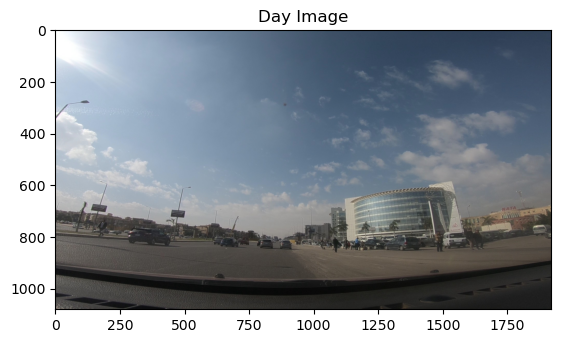

In [35]:
img=cv2.imread(os.path.join("day_night_clean","day",day_files[100]))
# remember that opencv loads data as BGR, change that to RGB to get ur image
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title("Day Image")

A naive solution is to take only a small subset of the night images. But I'll probably use f1-score as our accuracy of our model.

### Downsampling The Data

As we've seen we have around 22,000 night images and only 2,700 day images. To fix this we'll have to try downsampling the data. This will also speed-up our learning process, because the machine will have less data to work through.

In [45]:
# specifying the destination for subset of images
sub_dest = "sub_day_night"
sub_day=os.path.join(sub_dest,"day")
sub_night=os.path.join(sub_dest,"night")


def copy_subset(src_dir,list_of_files,dest_dir,final_idx=150):
    random.shuffle(list_of_files)
    for file in list_of_files[:final_idx]:
        dest_path=os.path.join(dest_dir,file)   
        if not os.path.exists(dest_dir):    
            os.makedirs(dest_dir)
        src_path=os.path.join(src_dir,file)

        shutil.copy(src_path,dest_path)


copy_subset(os.path.join("day_night_clean","day"),day_files,sub_day,final_idx=len(day_files))
copy_subset(os.path.join("day_night_clean","night"),night_files,sub_night,final_idx=len(day_files))


# SVM Classifier

The SVM model will demand that we resize our images first and flatten it.

##### Pre-processing For SVM

In [46]:
classes=["day", "night"]
new_dest="sub_day_night"

flat_imgs=[]
target=[]
for category in classes:
    cat_path=os.path.join(new_dest,category)
    cat_list=os.listdir(cat_path)
    random.shuffle(cat_list)
    for img_file in cat_list:
        img_path=os.path.join(cat_path,img_file)
        img=cv2.imread(img_path)
        img=sk_tfm.resize(img,(120,120,3))
        flat_imgs.append(img.flatten())
        target.append(classes.index(category))

# change lists to np array
flat_imgs=np.array(flat_imgs)
target=np.array(target)
        
        
        

In [47]:
print(len(flat_imgs))

5524


In [48]:
# convert to dataframe
svm_df=pd.DataFrame(flat_imgs) 
# add Target column
svm_df['Target']=target
svm_df.shape

(5524, 43201)

As you can see, the `svm_df` dataframe has 43,201 columns corresponding to our flattened (120,120,3) image, equals 120*120*3=43,200 and one extra column for the target. To train our model, we'll have to split this dataframe into x and y. We'll use pandas `iloc`

In [49]:
x=svm_df.iloc[:,:-1]
y=svm_df.iloc[:,-1]

#### Test Split

Split data into train and test. 

In [50]:
train_x, test_x, train_y, test_y=train_test_split(x,y,test_size=0.2)

### Model Definition

We'll make a simple Support Vector Classifier (SVC)

In [62]:
svc=svm.SVC(probability=True)
param_grid={'C':[0.1,1,10,100], 
            'gamma':[0.0001,0.001,0.1,1], 
            'kernel':['rbf','poly']} 
model_svm=RandomizedSearchCV(svc,param_grid,n_iter=5)

### Training Model

In [63]:
print("Train_x shape is: ",train_x.shape)
print("Train_y shape is: ",train_y.shape)

Train_x shape is:  (4419, 43200)
Train_y shape is:  (4419,)


Now let's fit our SVM model, this might take a while!

In [64]:
model_svm.fit(train_x,train_y)

RandomizedSearchCV(estimator=SVC(probability=True), n_iter=5,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'gamma': [0.0001, 0.001, 0.1, 1],
                                        'kernel': ['rbf', 'poly']})

Let's test our accuracy

In [65]:
y_pred=model_svm.predict(test_x)
accuracy=accuracy_score(y_true=test_y,y_pred=y_pred)
print(f"The accuracy of our model is {round(accuracy*100,ndigits=3)}%")

The accuracy of our model is 100.0%


That's too good actually. I am concerned that we might have done something wrong. Let's see our classification report.

In [66]:

print(classification_report(test_y, y_pred, target_names=['day', 'night']))

              precision    recall  f1-score   support

         day       1.00      1.00      1.00       556
       night       1.00      1.00      1.00       549

    accuracy                           1.00      1105
   macro avg       1.00      1.00      1.00      1105
weighted avg       1.00      1.00      1.00      1105



Seems good! Let's now try making a CNN model

In [81]:
with open('svm_model.pkl','wb') as f:
    pickle.dump(model_svm,f)


# CNN Using PyTorch

## Importing Libraries

In [1]:
from torchvision.transforms import v2
from torchvision import datasets
from torch.utils.data import *
import torch
from torch import nn
import torch.nn.functional as F

## Preprocessing

Those images are too big, so we'll have to put that in mind while pre-processing

In [2]:
transforms= v2.Compose([
    v2.RandomResizedCrop(size=(64,64)),
    v2.RandomHorizontalFlip(), #flipping image to its mirror shouldn't change our classification
    v2.ToImage(),  # this and the next line are the new ToTensor
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [51]:
dataset=datasets.ImageFolder(root='sub_day_night',transform=transforms)
train_set, val_set=torch.utils.data.random_split(dataset,[0.7,0.3])
train_loader=DataLoader(train_set, batch_size=128,shuffle=True)
val_loader=DataLoader(val_set, batch_size=128,shuffle=True)

### Model Definition

I'll use 3 convolution layers and pooling layers. Our model head will have fully connected layers and a sigmoid actiivation. I'll also use relu activation between intermediate layers.

In [53]:
class CNNModule(nn.Module):
    def __init__(self):
        super().__init__()
        #our first convolution layer
        self.conv1=nn.Conv2d(3,16,3,padding=1) 
        self.conv2=nn.Conv2d(16,32,3,padding=1)
        self.pool=nn.AvgPool2d(2,2)
        self.fc1=nn.Linear(16*16*32,512)
        self.fc2=nn.Linear(512,1)
        self.sigmoid=nn.Sigmoid()
        self.dropout=nn.Dropout(p=0.2)
    def forward(self,x):
        # input=64 x 64 x 3, output=32 x 32 x 16
        x=self.pool(F.relu(self.conv1(x)))
        # input=32 x 32 x 16, output=16 x 16 x 32
        x=self.pool(F.relu(self.conv2(x)))
        # flatten
        x=x.view(-1,16*16*32)
        # fully connected layer
        x=self.dropout(x)
        x=F.relu(self.fc1(x))
        self.dropout(x)
        x=F.relu(self.fc2(x))
        return x   




In [54]:
model_cnn=CNNModule()
criterion=nn.BCEWithLogitsLoss()
optimizer= torch.optim.SGD(model_cnn.parameters(), lr=0.01,momentum=0.9)


### Test For CUDA

In [55]:
train_gpu=torch.cuda.is_available()
if train_gpu:
    model_cnn.cuda()
    print("Training on GPU")

Training on GPU


### Training Loop

Let's make a scheduler, so that the model changes its learning rate when it stops learning.

In [56]:
scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=0.01,steps_per_epoch=len(train_loader),anneal_strategy="cos",epochs=20)

## Training Loop

In [58]:
max_epochs =20

for i in range(max_epochs):
    training_loss=0
    
    for images, labels in train_loader:
        #####################################
        ## Training #######################
        # to let dropout work when training model
        model_cnn.train()
        training_loss=0
        if train_gpu:
            # remember to put your data on the dame device as your model
            images=images.cuda()
            labels=labels.cuda()
        # 0) zero out the gradients, to avoid gradient accumulation
        optimizer.zero_grad()
        # 1) forward pass
        preds=model_cnn(images)
        # 2) measure loss
        loss=criterion(preds,labels.unsqueeze(1).float())
        training_loss+=loss.item()
        # 3) backward pass
        loss.backward()
        # 4) optimizer step
        optimizer.step()
        scheduler.step()
    else:
        validation_loss=0
        accuracy=0
        for images, labels in val_loader:
            #####################################
            ## VALIDATION #######################
            ###################################
            # save memory and computation by letting pytorch not measure gradients
            # to let dropout stop working when validating model
            model_cnn.eval()
            with torch.no_grad():        
                
                if train_gpu:
                    # remember to put your data on the dame device as your model
                    images=images.cuda()
                    labels=labels.cuda()
                # 1) forward pass
                preds=model_cnn(images)
                
                preds,y=preds.to(torch.float16), labels.view(*preds.shape).to(torch.float16)

            # validation loss
            validation_loss+=criterion(preds,y)        
            # check accuracy
            ps=torch.exp(preds)
            _,top_class=torch.topk(ps,1,dim=1)
            equals=(top_class==y)
            batch_accuracy=torch.mean(equals.type(torch.FloatTensor))
            accuracy+=batch_accuracy

    training_loss/=len(train_loader)
    validation_loss/=len(val_loader)

    print("For epoch {}\n, Validation loss is {:.3f}, Training Loss is {:.3f}, Accuracy is {:.3f}%"\
          .format((i+1),validation_loss,training_loss,(accuracy/len(val_loader))*100))



For epoch 1
, Validation loss is 0.385, Training Loss is 0.011, Accuracy is 49.898%
For epoch 2
, Validation loss is 0.386, Training Loss is 0.012, Accuracy is 49.915%
For epoch 3
, Validation loss is 0.380, Training Loss is 0.013, Accuracy is 49.905%


Now let;'s run our model for some epochs and see how well it performs.

# CNN using TensorFlow

## Importing Libraries

In [ ]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model